In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, accuracy_score, f1_score
import itertools

In [2]:
#file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025.csv"
file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025_norge.csv"
df = pd.read_csv(file_path, sep=";")

In [3]:
df = df[df["EGS.VEDTAK.10670"].notna()]

In [4]:
df['Avslag_ind'] = df['EGS.VEDTAK.10670'].apply(lambda x: 1 if x == "Avslag" else 0)

In [5]:
andel_avslag=df['Avslag_ind'].sum()/df['Avslag_ind'].count()

In [6]:
andel_avslag

0.030107526881720432

In [7]:
antall_avslag=df['Avslag_ind'].sum()

In [8]:
antall_avslag

28

In [9]:
df["Kurvatur, horisontal"]=df["Kurvatur, horisontalelement"]

In [10]:
features = [
    'Avslag_ind',
    "ÅDT, total",
    "ÅDT, andel lange kjøretøy",
    "Fartsgrense",
    "Avkjørsel, holdningsklasse",
    "Funksjonsklasse",
    "Avkjørsler",
    "Trafikkulykker",
    "EGS.BRUKSOMRÅDE.1256", 
    "Kurvatur, horisontal", 
    #"Kurvatur, horisontalelement", 
    "Kurvatur, stigning"
]

# Encode categorical features
df_encoded = pd.get_dummies(df[features])

In [11]:
df_encoded=df_encoded.dropna()

In [12]:
df_encoded['sving_ind'] = np.where(df_encoded['Kurvatur, horisontal'].abs() > 99000, 0, 1)

In [13]:
df_encoded['sving'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, df_encoded['Kurvatur, horisontal'].abs(), 0)

In [14]:
df_encoded['bakke_ind'] = np.where(df_encoded['Kurvatur, stigning'].abs() > 0.1, 1, 0)

In [15]:
df_encoded['sving_sigmoid'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs())), 0)

In [16]:
df_encoded['bakke']=df_encoded['Kurvatur, stigning'].abs()

In [17]:
df_encoded['bakke_sigmoid'] = 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs()))

In [18]:
df_encoded['antall_lange_kj']=df_encoded['ÅDT, total']*df_encoded['ÅDT, andel lange kjøretøy']/100

In [19]:
df_encoded = df_encoded.drop(['Kurvatur, horisontal', 'Kurvatur, stigning'], axis=1)

In [20]:
y = df_encoded['Avslag_ind']        # target
X = df_encoded.drop(columns=['Avslag_ind'])  # all other columns

In [21]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",Funksjonsklasse_A - Nasjonale hovedveger,...,EGS.BRUKSOMRÅDE.1256_Service,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk,EGS.BRUKSOMRÅDE.1256_Skole/Barnehage,sving_ind,sving,bakke_ind,sving_sigmoid,bakke,bakke_sigmoid,antall_lange_kj
0,100.0,10.0,80.0,0,0,True,False,False,False,False,...,False,False,False,1,558.0,1,0.635990,2.7,0.635990,10.0
1,850.0,14.0,50.0,0,4,True,False,False,False,False,...,False,False,False,1,24.0,1,0.506000,8.4,0.506000,119.0
2,800.0,10.0,60.0,0,0,False,False,True,False,False,...,False,False,False,0,0.0,1,0.000000,3.7,1.000000,80.0
3,6400.0,12.0,50.0,0,23,False,True,False,False,False,...,False,False,False,0,0.0,1,0.000000,0.7,1.000000,768.0
4,600.0,14.0,50.0,1,2,True,False,False,False,False,...,False,False,False,0,0.0,1,0.000000,1.8,1.000000,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,1300.0,6.0,30.0,21,0,True,False,False,False,False,...,False,False,False,1,1520.0,1,0.820538,0.5,0.820538,78.0
926,500.0,10.0,60.0,12,2,False,False,True,False,False,...,False,False,False,1,1119.0,1,0.753803,0.2,0.753803,50.0
927,400.0,13.0,60.0,12,0,False,False,False,True,False,...,False,False,False,1,192.0,1,0.547853,5.5,0.547853,52.0
928,1600.0,15.0,80.0,8,6,False,False,False,True,False,...,False,True,False,1,524.0,1,0.628083,3.0,0.628083,240.0


In [22]:
poly = PolynomialFeatures(3, include_bias=False, interaction_only=True) 
X = pd.DataFrame(
    poly.fit_transform(X),
    columns=poly.get_feature_names_out(X.columns)
)

In [23]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",Funksjonsklasse_A - Nasjonale hovedveger,...,bakke_ind sving_sigmoid bakke,bakke_ind sving_sigmoid bakke_sigmoid,bakke_ind sving_sigmoid antall_lange_kj,bakke_ind bakke bakke_sigmoid,bakke_ind bakke antall_lange_kj,bakke_ind bakke_sigmoid antall_lange_kj,sving_sigmoid bakke bakke_sigmoid,sving_sigmoid bakke antall_lange_kj,sving_sigmoid bakke_sigmoid antall_lange_kj,bakke bakke_sigmoid antall_lange_kj
0,100.0,10.0,80.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.717172,0.404483,6.359897,1.717172,27.0,6.359897,1.092104,17.171721,4.044828,17.171721
1,850.0,14.0,50.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,...,4.250398,0.256036,60.213966,4.250398,999.6,60.213966,2.150700,505.797312,30.468249,505.797312
2,800.0,10.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.000000,0.000000,3.700000,296.0,80.000000,0.000000,0.000000,0.000000,296.000000
3,6400.0,12.0,50.0,0.0,23.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.700000,537.6,768.000000,0.000000,0.000000,0.000000,537.600000
4,600.0,14.0,50.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,1.800000,151.2,84.000000,0.000000,0.000000,0.000000,151.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,1300.0,6.0,30.0,21.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.410269,0.673283,64.002001,0.410269,39.0,64.002001,0.336642,32.001001,52.516105,32.001001
852,500.0,10.0,60.0,12.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0.150761,0.568219,37.690159,0.150761,10.0,37.690159,0.113644,7.538032,28.410962,7.538032
853,400.0,13.0,60.0,12.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.013192,0.300143,28.488360,3.013192,286.0,28.488360,1.650787,156.685982,15.607436,156.685982
854,1600.0,15.0,80.0,8.0,6.0,0.0,0.0,0.0,1.0,0.0,...,1.884248,0.394488,150.739830,1.884248,720.0,150.739830,1.183463,452.219489,94.677068,452.219489


In [24]:
andel_avslag=y.sum()/y.count()

In [25]:
#X=df_with_interactions
#scaler = PowerTransformer()
#X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [26]:
# Identify binary dummy columns: only {0,1} or {0.0,1.0}
binary_cols = [
    col for col in X.columns
    if np.isin(X[col].dropna().unique(), [0,1]).all()
]

continuous_cols = [col for col in X.columns if col not in binary_cols]

# Transform only continuous columns
scaler = PowerTransformer()
X_cont_scaled = pd.DataFrame(
    scaler.fit_transform(X[continuous_cols]),
    columns=continuous_cols,
    index=X.index
)

# Combine back into full feature matrix
X = pd.concat([X_cont_scaled, X[binary_cols]], axis=1)

In [27]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,sving,sving_sigmoid,bakke,bakke_sigmoid,antall_lange_kj,...,EGS.BRUKSOMRÅDE.1256_Service sving_ind bakke_ind,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage sving_ind,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage sving,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_ind,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage sving_sigmoid,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_sigmoid,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage antall_lange_kj,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk sving_ind bakke_ind,EGS.BRUKSOMRÅDE.1256_Skole/Barnehage sving_ind bakke_ind
0,-1.723294,0.029680,1.088215,-1.569219,-1.048636,0.991172,0.852758,0.236383,-0.711888,-1.665175,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.383912,0.950345,-1.027326,-1.569219,1.079252,-0.106715,0.462071,1.698913,-1.354748,0.671953,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.329036,0.029680,-0.377069,-1.569219,-1.048636,-1.123036,-1.139155,0.613695,1.064664,0.315548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.063733,0.534235,-1.027326,-1.569219,1.872248,-1.123036,-1.139155,-1.000100,1.064664,2.222125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.064912,0.950345,-1.027326,-1.160739,0.611224,-1.123036,-1.139155,-0.205003,1.064664,0.359820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,0.760973,-1.443492,-2.136054,1.379377,-1.048636,1.371481,1.395926,-1.200520,0.192875,0.292522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
852,-0.105697,0.029680,-0.377069,0.620790,0.611224,1.253764,1.200974,-1.558818,-0.133283,-0.117542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
853,-0.317948,0.751545,-0.377069,0.620790,-1.048636,0.601686,0.588643,1.122815,-1.147229,-0.080960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
854,0.940522,1.133297,1.088215,0.169913,1.317421,0.967778,0.829193,0.359500,-0.750854,1.279139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [28]:
model = RandomForestClassifier(
    n_estimators=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)
importances
# Select top 10 features
top_features = importances_sorted.index[:15]
X_top = X[top_features]

In [29]:
importances_sorted

Fartsgrense bakke bakke_sigmoid                                                                                            0.006290
ÅDT, andel lange kjøretøy bakke bakke_sigmoid                                                                              0.005259
bakke bakke_sigmoid                                                                                                        0.005248
ÅDT, andel lange kjøretøy Fartsgrense bakke                                                                                0.004920
ÅDT, total bakke_ind bakke                                                                                                 0.004393
                                                                                                                             ...   
Avkjørsel, holdningsklasse_Lite streng Funksjonsklasse_B - Regionale hovedveger Funksjonsklasse_D - Lokale samleveger      0.000000
Avkjørsel, holdningsklasse_Lite streng Funksjonsklasse_B - Regionale hovedve

In [30]:
X=X_top

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=43)

In [32]:
X_train_orig=X_train
y_train_orig=y_train

In [33]:
smote = ADASYN(sampling_strategy=0.3, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [34]:
# Fit logistic regression
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [35]:
yps=model.predict_proba(X_test)

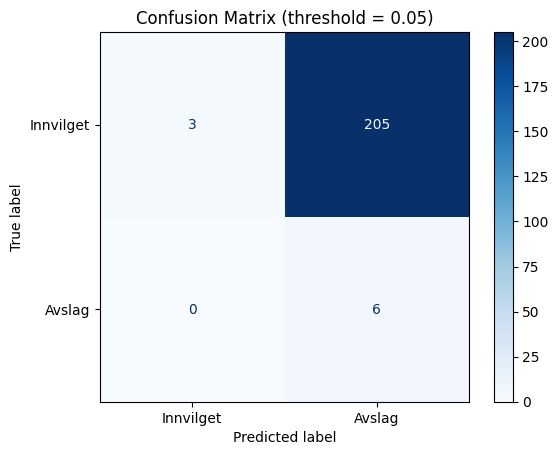

In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicted probabilities for class "1"
y_prob = yps[:, 1]

# Adjustable threshold
threshold = 0.05 # 👈 change this value between 0 and 1

# Convert probabilities to class predictions
y_pred = (y_prob >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Innvilget", "Avslag"])

# Plot
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

In [37]:
# Detailed metrics per class
print("Classification Report Logistic regression:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report Logistic regression:
              precision    recall  f1-score   support

           0     1.0000    0.0144    0.0284       208
           1     0.0284    1.0000    0.0553         6

    accuracy                         0.0421       214
   macro avg     0.5142    0.5072    0.0419       214
weighted avg     0.9728    0.0421    0.0292       214



In [38]:
model = RandomForestClassifier(n_estimators=5000,n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5000, n_jobs=-1)

In [39]:
yps=model.predict_proba(X_test)

In [40]:
X_test

,Fartsgrense bakke bakke_sigmoid,"ÅDT, andel lange kjøretøy bakke bakke_sigmoid",bakke bakke_sigmoid,"ÅDT, andel lange kjøretøy Fartsgrense bakke","ÅDT, total bakke_ind bakke",Fartsgrense Avkjørsler bakke,"ÅDT, total bakke",bakke_ind bakke bakke_sigmoid,"Avkjørsel, holdningsklasse_Streng EGS.BRUKSOMRÅDE.1256_Bolig bakke","ÅDT, total bakke antall_lange_kj","ÅDT, andel lange kjøretøy Fartsgrense antall_lange_kj",Fartsgrense Avkjørsler bakke_sigmoid,Fartsgrense bakke_ind bakke,"ÅDT, andel lange kjøretøy Avkjørsler bakke_sigmoid",Fartsgrense bakke_ind antall_lange_kj
509,-1.224226,-0.678184,-1.204437,-0.667356,0.453561,0.078737,0.478139,-1.180145,3.639446,1.462145,2.330959,0.752011,-1.061328,1.625771,2.329358
122,-0.629510,-0.166033,-0.327382,-0.718670,-0.012100,-0.169238,-0.013010,-0.325641,-0.282660,0.233116,0.201573,0.074781,-0.794828,0.513169,0.126854
275,1.171047,1.234541,1.334774,0.760142,0.770583,-0.300283,0.802000,1.333445,-0.282660,0.615839,0.220099,-0.903836,0.790332,-0.868190,0.215098
11,0.855025,1.150688,1.005562,1.425722,1.647552,-1.668259,1.661146,1.000432,-0.282660,1.537079,1.072983,-1.747105,1.261513,-1.655931,0.979967
506,-1.796599,-1.812853,-1.646797,-1.891732,-2.254597,-0.693781,-0.666134,-1.788652,2.412044,0.198025,0.951923,1.294043,-2.101869,1.153185,-2.335764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,-0.807344,-0.387112,-1.083911,-0.206355,-0.314636,-0.112899,-0.343468,-1.063515,-0.282660,0.353215,1.935941,0.579860,-0.794828,1.061365,1.514787
464,1.312266,0.015094,1.093273,-0.043540,3.002566,0.866907,2.905131,1.088933,-0.282660,2.661899,1.036001,0.577808,0.920661,-0.338522,2.145135
249,0.717046,0.359116,0.494092,0.269950,0.098422,1.183272,0.105371,0.487487,-0.282660,0.008248,-0.005179,1.644926,0.376659,1.052252,0.086685
801,-0.922995,-0.982005,-1.011847,-0.703730,0.225492,0.150845,0.240043,-0.993662,-0.282660,0.554991,0.663946,0.211304,-0.650501,0.146586,0.762923


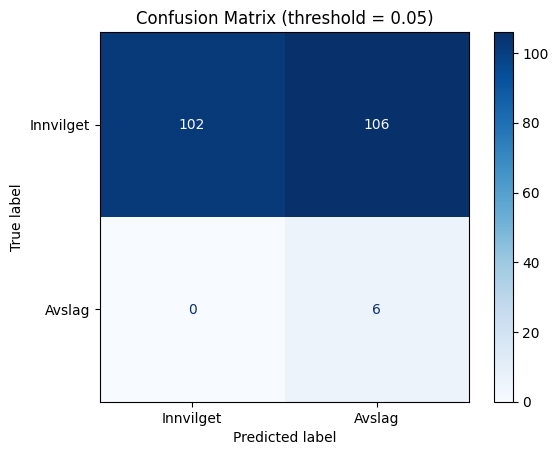

In [41]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicted probabilities for class "1"
y_prob = yps[:, 1]

# Adjustable threshold
threshold = 0.05 # 👈 change this value between 0 and 1

# Convert probabilities to class predictions
y_pred = (y_prob >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Innvilget", "Avslag"])

# Plot
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

In [42]:
# Detailed metrics per class
print("Classification Report Random Forrest:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report Random Forrest:
              precision    recall  f1-score   support

           0     1.0000    0.4904    0.6581       208
           1     0.0536    1.0000    0.1017         6

    accuracy                         0.5047       214
   macro avg     0.5268    0.7452    0.3799       214
weighted avg     0.9735    0.5047    0.6425       214



In [43]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values(ascending=False)

In [44]:
print(importances_sorted)

ÅDT, andel lange kjøretøy Fartsgrense antall_lange_kj                 0.101996
Fartsgrense Avkjørsler bakke_sigmoid                                  0.093547
ÅDT, andel lange kjøretøy Avkjørsler bakke_sigmoid                    0.089368
Fartsgrense bakke_ind antall_lange_kj                                 0.080494
Fartsgrense Avkjørsler bakke                                          0.071674
ÅDT, andel lange kjøretøy Fartsgrense bakke                           0.068428
Fartsgrense bakke_ind bakke                                           0.059295
ÅDT, total bakke antall_lange_kj                                      0.058372
bakke bakke_sigmoid                                                   0.057487
bakke_ind bakke bakke_sigmoid                                         0.056211
Fartsgrense bakke bakke_sigmoid                                       0.054414
ÅDT, andel lange kjøretøy bakke bakke_sigmoid                         0.053112
ÅDT, total bakke                                    

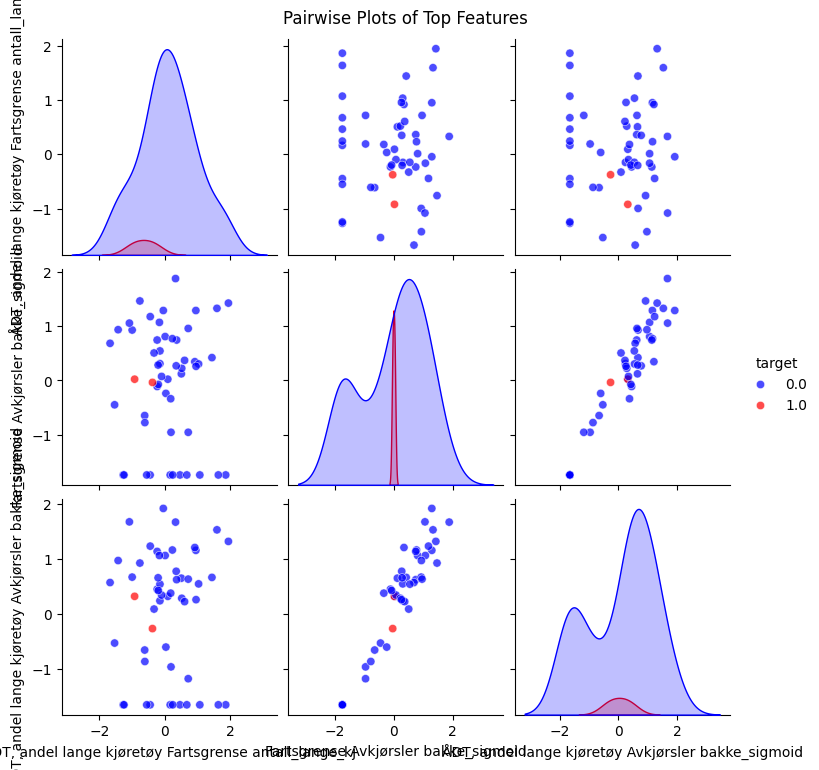

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top 4 features
top_features = importances_sorted.index[:3]

# Subset data
X_top = X_test[top_features].copy()
X_top['target'] = y_test  # add the target

# Pairwise scatter plots
sns.pairplot(
    X_top,
    vars=top_features,
    hue='target',            # color by target
    palette={0: "blue", 1: "red"}, 
    plot_kws={'alpha': 0.7}
)
plt.suptitle("Pairwise Plots of Top Features", y=1.02)
plt.show()

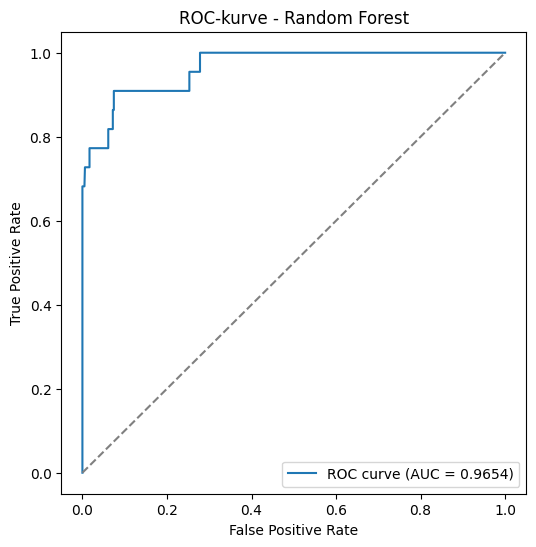

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Sannsynligheter for den positive klassen
y_proba = model.predict_proba(X)[:, 1]

# Beregn ROC-verdier
fpr, tpr, thresholds = roc_curve(y, y_proba)
auc = roc_auc_score(y, y_proba)

# Plott ROC-kurve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-kurve - Random Forest')
plt.legend(loc='lower right')
plt.show()

In [47]:
#Kort sagt: hver x-verdi viser hvor mange negative som blir feil, hver y-verdi viser hvor mange positive som blir riktig.

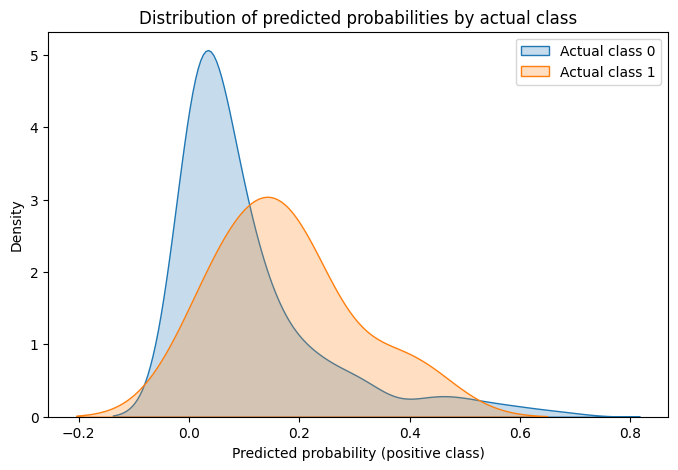

In [48]:
y_proba = yps[:, 1]

# Combine into one DataFrame for easy plotting
import pandas as pd
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()

In [49]:
from imblearn.ensemble import BalancedRandomForestClassifier
model = BalancedRandomForestClassifier(n_estimators=1000,sampling_strategy=0.3,
                              random_state=42, n_jobs=-1)
model.fit(X_train_orig, y_train_orig)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

C:\Users\jens.nilsen\python\WPy64-31241\python-3.12.4.amd64\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\jens.nilsen\python\WPy64-31241\python-3.12.4.amd64\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


In [50]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9738    0.8942    0.9323       208
           1     0.0435    0.1667    0.0690         6

    accuracy                         0.8738       214
   macro avg     0.5087    0.5304    0.5006       214
weighted avg     0.9477    0.8738    0.9081       214



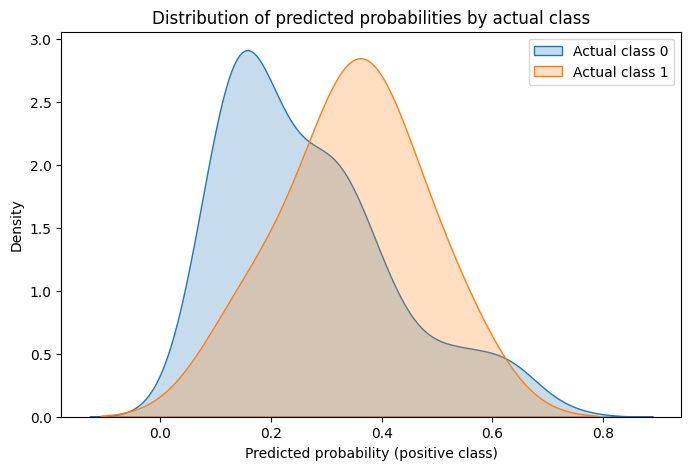

In [51]:
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()

In [52]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np

# Calculate imbalance ratio
pos = np.sum(y_train_orig == 1)
neg = np.sum(y_train_orig == 0)
scale_pos_weight = neg / pos  # also try tuning around this

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',  
    n_jobs=-1,
    random_state=42,
    tree_method="hist",    # fast modern tree builder
)

param_distributions = {
    "n_estimators": randint(50, 5000),
    "learning_rate": uniform(0.001, 1.0),
    "max_depth": randint(3, 15),
    "min_child_weight": randint(1, 10),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.1, 0.9),
    "gamma": uniform(0, 5),
    "reg_alpha": uniform(0, 5),
    "reg_lambda": uniform(0, 5),
    "scale_pos_weight": uniform(scale_pos_weight*0.5, scale_pos_weight*1.5)
}

search = RandomizedSearchCV(
    xgb,
    param_distributions=param_distributions,
    n_iter=100,                    # increase to 150 if you have time
    scoring="f1_macro",
    cv=4,
    verbose=1,
    random_state=42,
    n_jobs=-1,
)

search.fit(X_train_orig, y_train_orig)

print("Best score:", search.best_score_)
print("Best params:", search.best_params_)

model = search.best_estimator_


Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best score: 0.6016941391941393
Best params: {'colsample_bytree': 0.1585464336867516, 'gamma': 4.7444276862666666, 'learning_rate': 0.9666320330745594, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 2662, 'reg_alpha': 1.1544691281107449, 'reg_lambda': 1.2051273301300585, 'scale_pos_weight': 59.66152776106908, 'subsample': 0.8439986631130484}


In [53]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

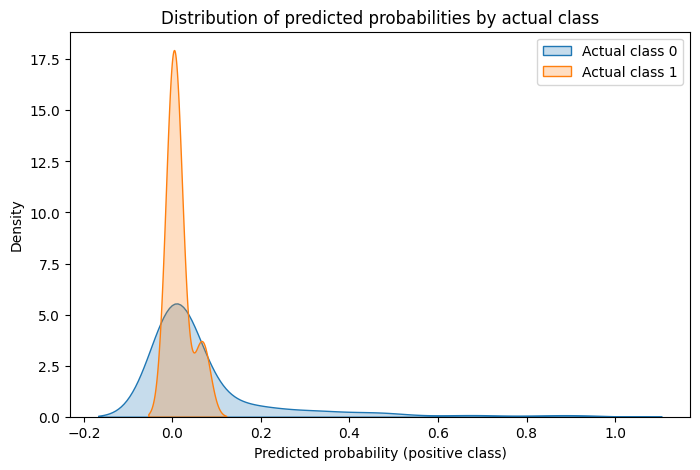

In [54]:
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()